<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper/ecoli_modeling_with_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the perfomance of LSTM model on simulation of E. coli in a Laotian catchment with different transformations of E. coli.

In [1]:
try:
    import ai4water
except ModuleNotFoundError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

  Cloning https://github.com/AtrCheema/AI4Water.git (to revision dev) to /tmp/pip-install-nx6bnc55/AI4Water
  Running command git clone -q https://github.com/AtrCheema/AI4Water.git /tmp/pip-install-nx6bnc55/AI4Water
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 2.9MB 29.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 69.2MB 117kB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
     |████████████████████████████████| 225kB 43.9MB/s 
     |████████████████████████████████| 296kB 41.9MB/s 
     |████████████████████████████████| 460kB 42.9MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |███████████████

In [2]:
from ai4water.datasets import MtropicsLaos
from ai4water.experiments import TransformationExperiments

ERROR! Session/line number was not unique in database. History logging moved to new session 28258


Download the data for Laos. The following command will download the data from [MTROPICS](https://mtropics.obs-mip.fr/catalogue-m-tropics/) website it it has not already been downloaded. Running this command may take time depending upon your internet connection.

In [3]:
laos = MtropicsLaos()


Not downloading the data since the directory 
D:\mytools\AI4Water\ai4water\datasets\data\MtropicsLaos already exists.
Use overwrite=True to remove previously saved files and download again


D:\mytools\AI4Water\ai4water\datasets\datasets.py:1355: UserWarning: preprocessing of shapefiles can not be done because no fiona installation is found.
  warnings.warn("preprocessing of shapefiles can not be done because no fiona installation is found.")


Fetch precipitation data from 2011 to 2018

In [5]:
data = laos.make_regression(lookback_steps=20)
data.shape

ERROR! Session/line number was not unique in database. History logging moved to new session 28259


D:\mytools\AI4Water\ai4water\datasets\datasets.py:1159: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return wl.loc[st:en], spm.loc[st:en]


(4071, 8)

In [6]:
data.columns

Index(['temp', 'rel_hum', 'wind_speed', 'sol_rad', 'water_level', 'pcp',
       'susp_pm', 'Ecoli_mpn100'],
      dtype='object')

In [7]:
data.head()

,temp,rel_hum,wind_speed,sol_rad,water_level,pcp,susp_pm,Ecoli_mpn100
2011-05-25 14:42:00,22.9,100.0,4.9,187.4,133.0,0.0,0.9,NaN
2011-05-25 14:48:00,22.9,100.0,4.6,177.6,133.0,0.0,0.9,NaN
2011-05-25 14:54:00,22.9,100.0,4.3,167.8,133.0,0.0,0.9,NaN
2011-05-25 15:00:00,22.9,100.0,4.0,158.0,133.0,0.0,0.9,NaN
2011-05-25 15:06:00,22.9,100.0,3.7,150.0,133.0,0.0,0.9,NaN


In [8]:
data.tail()

,temp,rel_hum,wind_speed,sol_rad,water_level,pcp,susp_pm,Ecoli_mpn100
2018-10-19 14:06:00,33.19,64.09,0.3026,211.968,137.2500,0.0,0.503473,NaN
2018-10-19 14:12:00,33.38,63.28,0.2812,208.764,137.2375,0.0,0.503329,NaN
2018-10-19 14:18:00,33.57,62.47,0.2598,205.560,137.2250,0.0,0.503184,NaN
2018-10-19 14:24:00,33.76,61.66,0.2384,202.356,137.2125,0.0,0.503039,NaN
2018-10-19 14:30:00,33.95,60.85,0.2170,199.152,137.2000,0.0,0.502894,120.0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

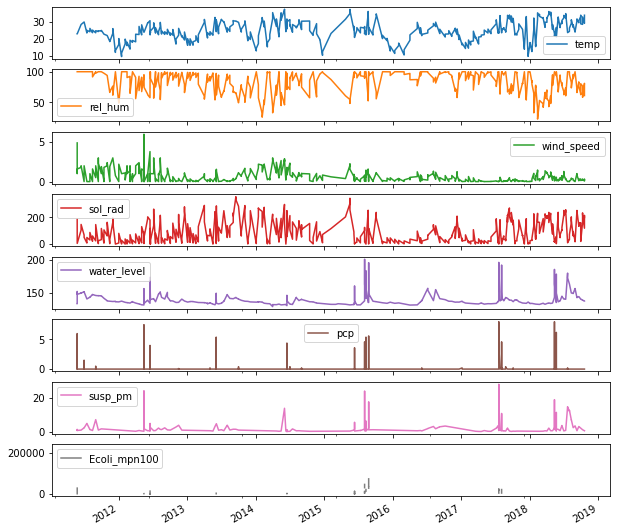

In [10]:
data.plot(subplots=True, sharex=True, figsize=(10, 10))

Define transformation cases

In [12]:
cases = {
    'baseline': {'y_transformation': None},
    'logn': {'y_transformation':{'method': 'log',
                              'replace_zeros': True}},
    'log10': {'y_transformation': {'method': 'log10',
                                     'replace_zeros': True}},
    'robust': {'y_transformation': 'robust'},
    'zscore': {'y_transformation': 'zscore'},
    'minmax': {'y_transformation': 'minmax'},
    'sqrt': {'y_transformation': 'sqrt'},
    'quantile': {'y_transformation': {'method': 'quantile', 'n_quantiles': 50}},
}

arguments for model setup

In [13]:
model_args = {
    'epochs': 500,
    'patience': 50,
    'test_fraction': 0.25,
    'val_data': 'same',
    'train_data': 'random',
    'input_features': data.columns.tolist()[0:-1],
    'output_features': data.columns.tolist()[-1:],
    'verbosity': 0
}

In [14]:
class MyTransformationExperiment(TransformationExperiments):

    def update_paras(self, **suggested_paras):
        """This method must update all the parameters to build the dl4sq 'Model'."""
        return {
            'model': {
                'layers': {
                    "LSTM": {"units": suggested_paras.get('lstm_units', 64), "dropout": 0.2},
                    "Dense": 1
                }
            },
            'lookback': suggested_paras.get('lookback', 10),
            'batch_size': suggested_paras.get('batch_size', 8),
            'lr': suggested_paras.get('lr', 0.001),
            'y_transformation': suggested_paras['y_transformation']
        }

Initialize the experiment

In [15]:
experiment = MyTransformationExperiment(cases=cases,
                                        exp_name='ecoli_output_transformation',
                                        **model_args)

In [16]:
experiment.models

['model_baseline',
 'model_logn',
 'model_log10',
 'model_robust',
 'model_zscore',
 'model_minmax',
 'model_sqrt',
 'model_quantile']

running  model_baseline model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.pre

running  model_logn model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: invalid value encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: invalid value encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWa

running  model_log10 model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: invalid value encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: invalid value encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWa

running  model_robust model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: Runti

running  model_zscore model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


running  model_minmax model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: Runti

running  model_sqrt model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: Runtime

running  model_quantile model


D:\mytools\AI4Water\ai4water\preprocessing\datahandler.py:934: UserWarning: Setting val_fraction from 0.2 to 0.0
  warnings.warn(f"Setting val_fraction from {self.config['val_fraction']} to 0.0")
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: divide by zero encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)
d:\c\anaconda3\envs\tfcpu115_py37\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: Runtime

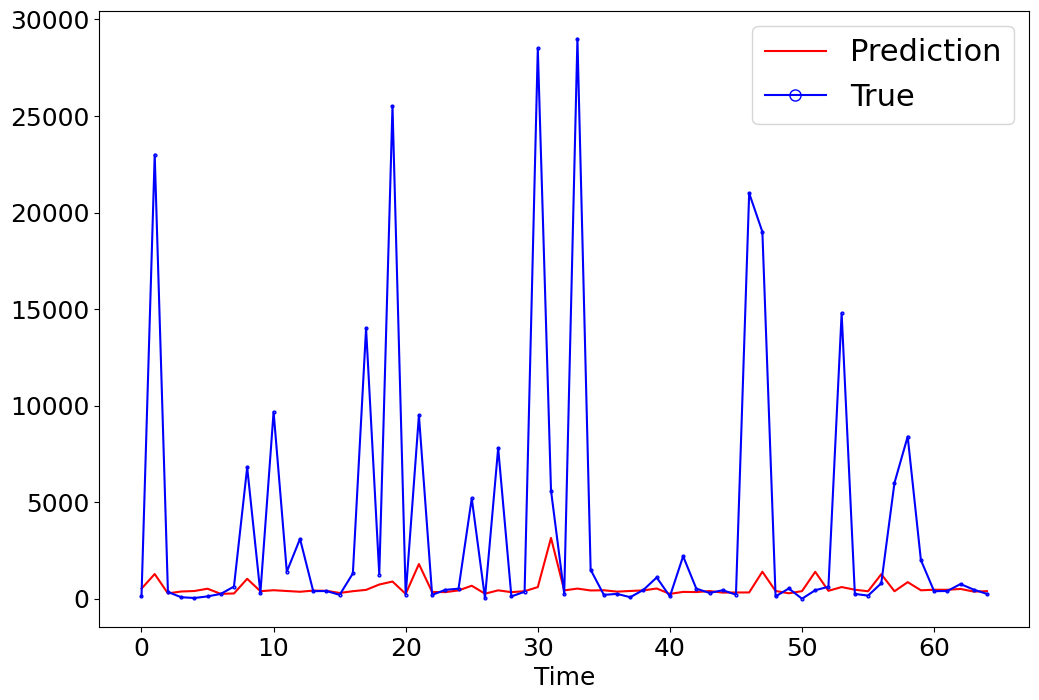

In [17]:
experiment.fit(data=data)

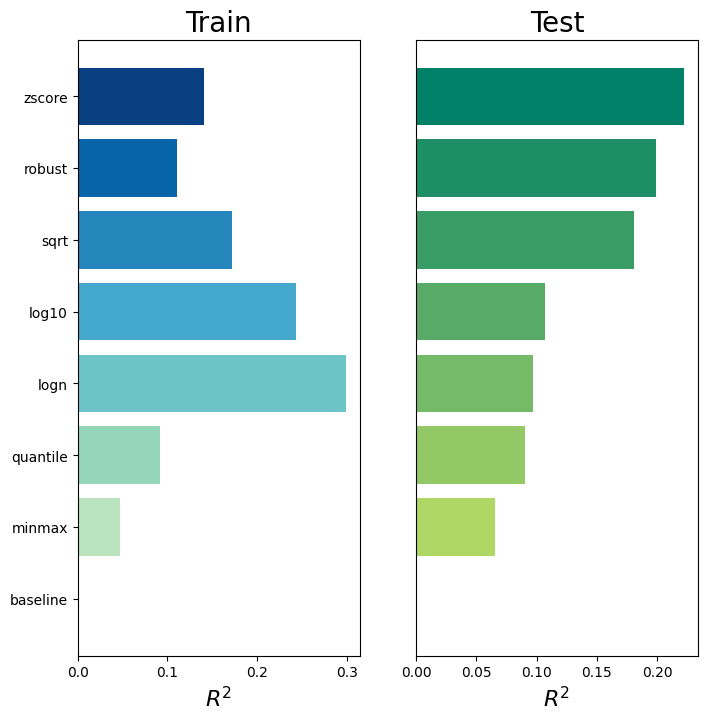

{0.22278591577560292: [0.1404694153302507, 'zscore'],
 0.19914498657817603: [0.11035902513806226, 'robust'],
 0.18085532582355146: [0.17147437648501945, 'sqrt'],
 0.10668984117544156: [0.24352506635841564, 'log10'],
 0.09669480240523942: [0.2994294537033461, 'logn'],
 0.09049017590980757: [0.09135564370510037, 'quantile'],
 0.06563131673690581: [0.0471383041652555, 'minmax'],
 6.309469172240123e-05: [0.0006253798386217152, 'baseline']}

In [18]:
experiment.compare_errors('r2')

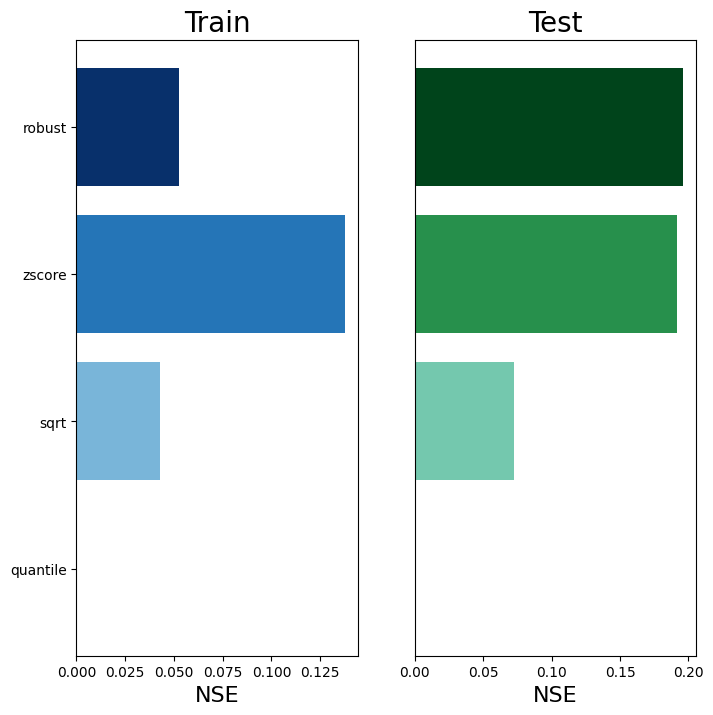

In [19]:
NSEs = experiment.compare_errors('nse')

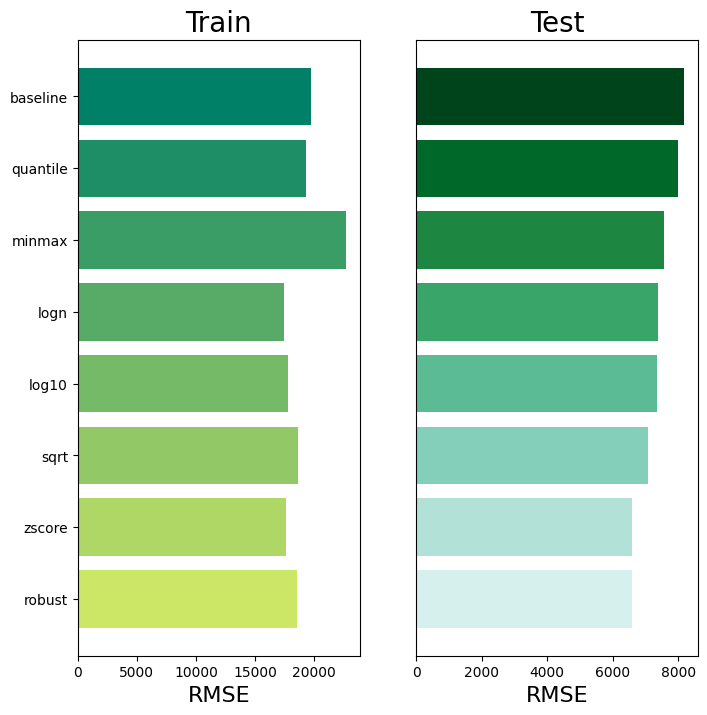

In [20]:
RMSEs = experiment.compare_errors('rmse')

D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:811: RuntimeWarning: invalid value encountered in log1p
  return float(np.average((np.log1p(self.true) - np.log1p(self.predicted)) ** 2, axis=0, weights=weights))


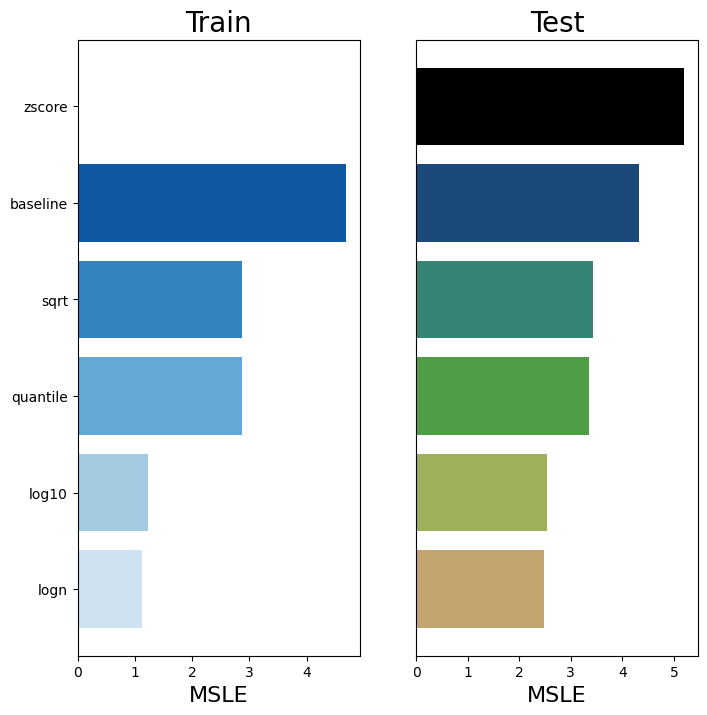

In [21]:
MSLEs = experiment.compare_errors('msle')

D:\mytools\AI4Water\ai4water\postprocessing\SeqMetrics\_regression.py:648: RuntimeWarning: invalid value encountered in true_divide
  return float(np.mean(np.abs((self.true - self.predicted) / self.true)) * 100)


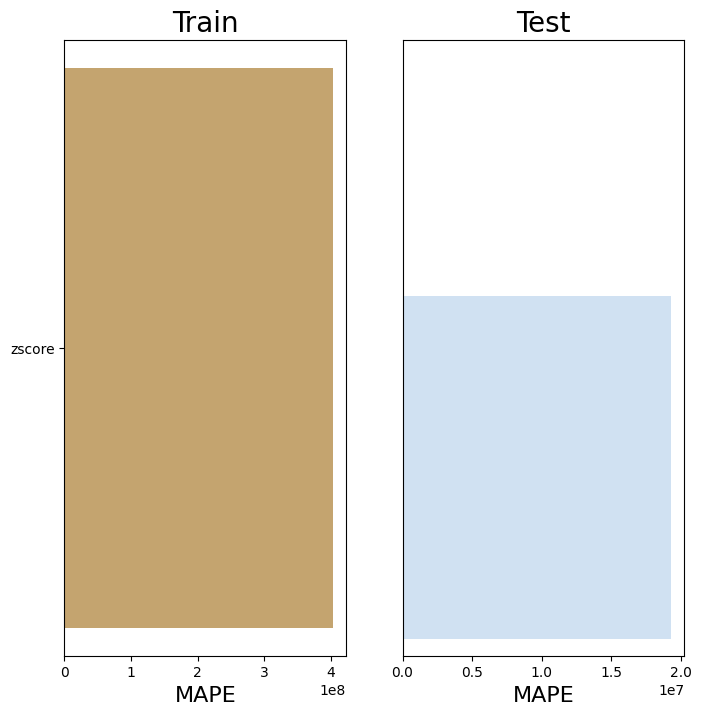

In [22]:
MAPEs = experiment.compare_errors('mape')

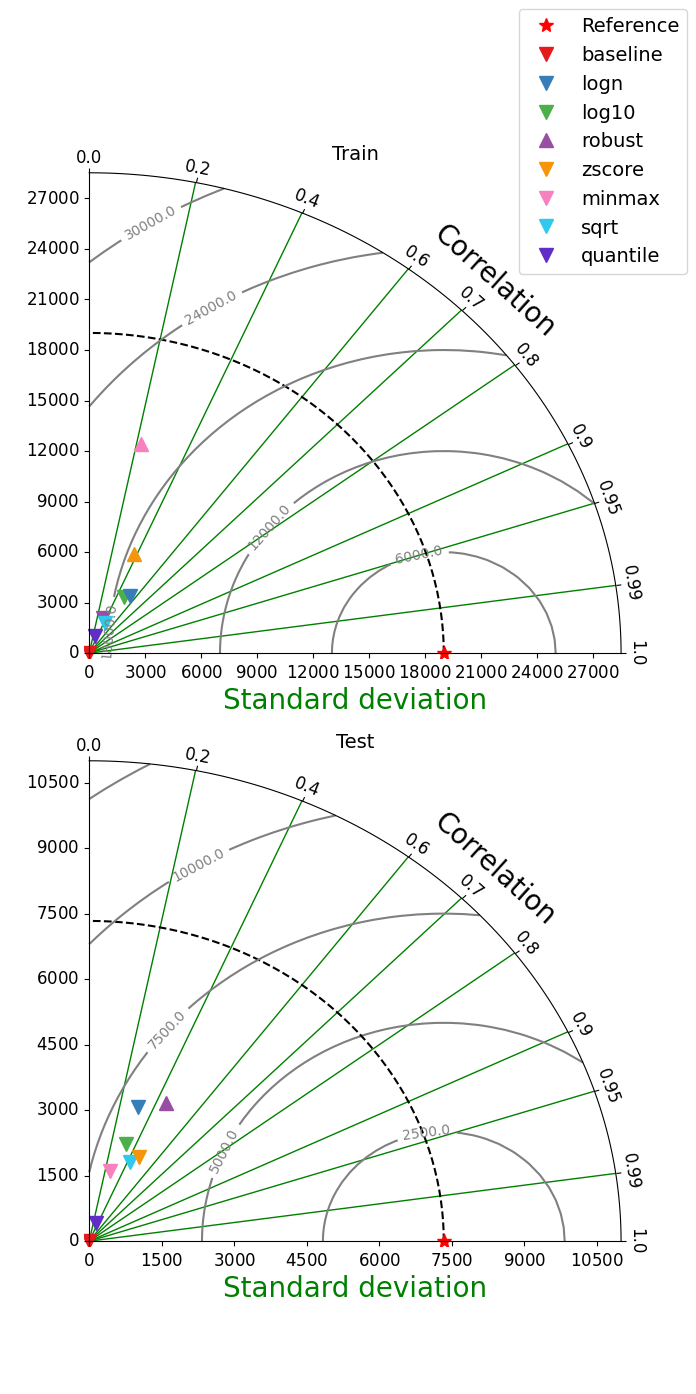

In [23]:
experiment.taylor_plot(
             figsize=(7, 14),
             plot_bias=True,
             grid_kws={'axis': 'x', 'color': 'g', 'lw': 1.0},
             leg_kws = {'fontsize': 14},
             axis_fontdict ={'left': {'fontsize': 20, 'color': 'k', 'ticklabel_fs': 12},
                             'bottom': {'fontsize': 20, 'color': 'g', 'ticklabel_fs': 12},
                             'top': {'fontsize': 20, 'color': 'k', 'ticklabel_fs': 12}}
            )

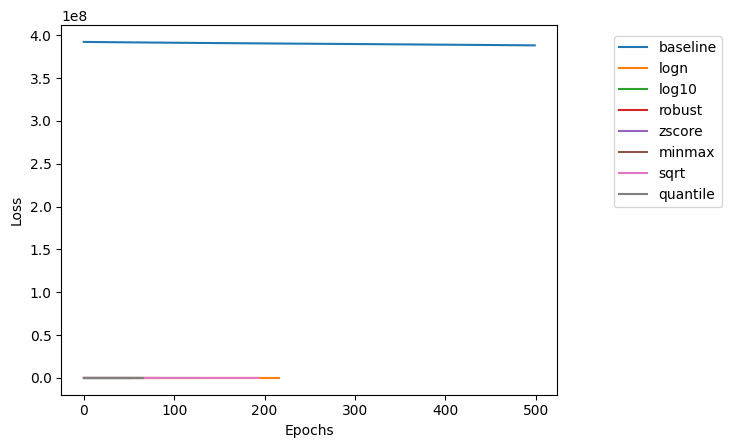

<AxesSubplot:xlabel='Epochs', ylabel='Loss'>

In [24]:
experiment.plot_losses('loss')

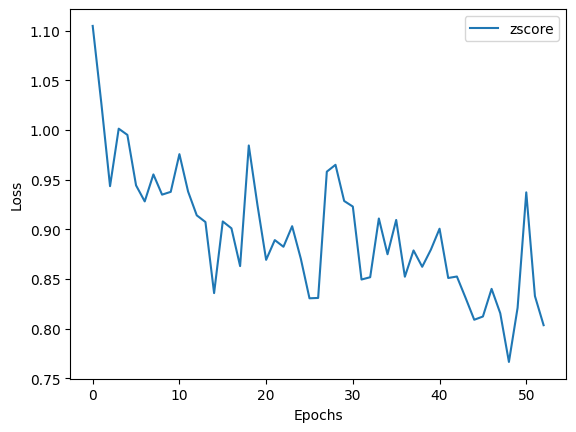

<AxesSubplot:xlabel='Epochs', ylabel='Loss'>

In [28]:
experiment.plot_losses('loss', include=['zscore'])

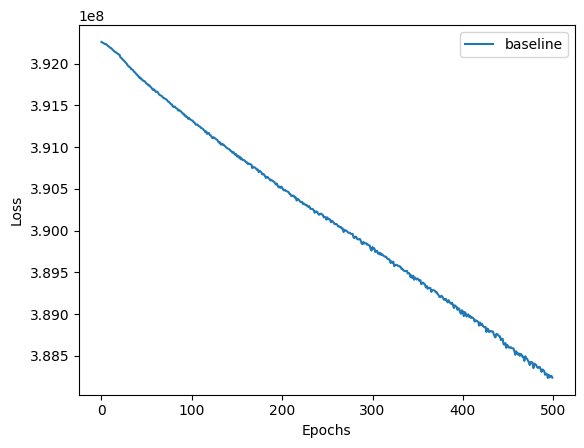

<AxesSubplot:xlabel='Epochs', ylabel='Loss'>

In [29]:
experiment.plot_losses('loss', include=['baseline'])

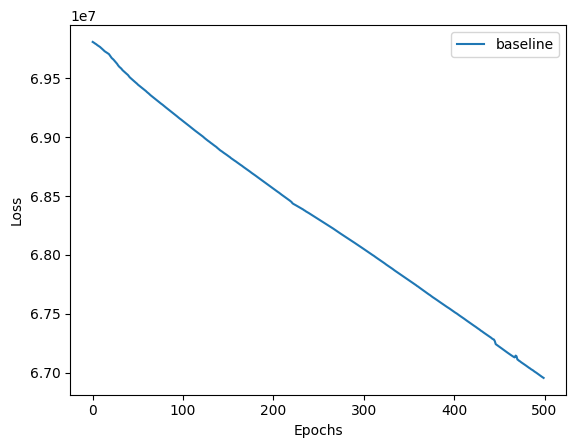

<AxesSubplot:xlabel='Epochs', ylabel='Loss'>

In [32]:
experiment.plot_losses('val_loss', include=['baseline'])

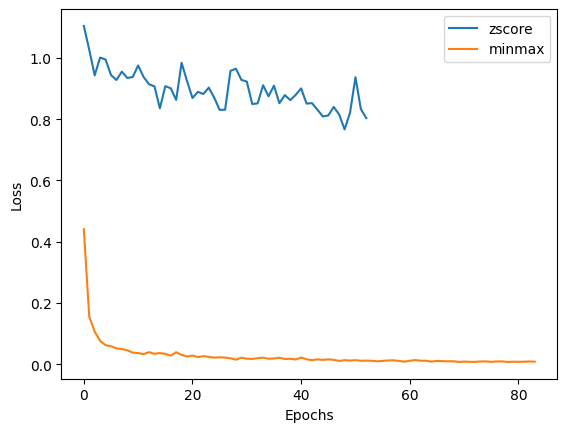

<AxesSubplot:xlabel='Epochs', ylabel='Loss'>

In [30]:
experiment.plot_losses('loss', include=['zscore', 'minmax'])

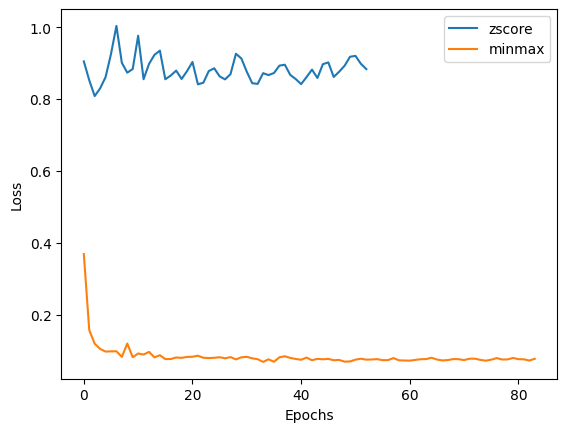

<AxesSubplot:xlabel='Epochs', ylabel='Loss'>

In [31]:
experiment.plot_losses('val_loss', include=['zscore', 'minmax'])

Exercise: 

- Run the experiments with more epochs (about 3000) and compare the results
- Run the experiments and optimize the hyperparameters in each case. This can be acheived by setting `run_type` argument to `optimzie` in `fit` function. and compare teh results.